# 04 - LTspice vs Dynamic Phasor Framework Comparison

This notebook compares the **LTspice** simulation results with the **Dynamic Phasor Framework** for the Rim et al. (2025) series RLC circuit.

## Methods Compared

1. **LTspice** (ground truth) - loaded from `ltspice_simulations/rim2025/rim2025.raw`
2. **Framework Time-Domain** - classical ODE integration
3. **Framework Phasor-Domain (IDP)** - Instantaneous Dynamic Phasor

## LTspice Netlist

```spice
V1 N001 N004 SINE(0 1 92.3k 0 0 0)
R1 N002 N001 3
L1 N002 N003 100.04µ Rser=1m
C1 N003 N004 30.07n
R2 N003 N004 2k
.tran 0 0.5m 0 1u
.backanno
.end
```

**Note**: In this LTspice schematic, `N004` is the ground reference node. The framework requires explicit node `0` as ground, so we map `N004 → 0`.

### Circuit Topology

```
       R1(3Ω)    L1(100.04µH)
 N001 ---/\/\/--- N002 ---UUUU--- N003 ---+---+
  +                                       |   |
 V1 (1V, 92.3kHz)                   C1(30.07n) R2(2kΩ)
  -                                       |   |
 N004(GND) --------------------------------+---+
```

### LTspice Files

The actual LTspice simulation files are in:
`framework/dynamic_phasor_LTspice/ltspice_simulations/rim2025/`

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Add framework to path
sys.path.insert(0, '../dynamic_phasor_LTspice')

from core.netlist_parser import parse_ltspice_netlist
from core.mna_circuit import NetlistCircuit
from core.ltspice_raw_reader import read_raw

plt.rcParams.update({
    'figure.figsize': (14, 5),
    'font.size': 11,
    'lines.linewidth': 1.5,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

print('Imports OK')

Imports OK


## 1. Framework Simulation

Parse the LTspice netlist (with `N004 → 0` mapping) and run both time-domain and phasor-domain simulations.

In [2]:
# Original LTspice netlist with N004 mapped to ground (0)
# L1 Rser=1m is parsed but negligible (1mΩ vs Rs=3Ω)
netlist_text = """
* Rim et al. (2025) RLC - exact LTspice circuit (N004→0)
V1 N001 0 SINE(0 1 92.3k 0 0 0)
R1 N002 N001 3
L1 N002 N003 100.04u Rser=1m
C1 N003 0 30.07n
R2 N003 0 2k
.tran 0 0.5m 0 1u
.end
"""

netlist = parse_ltspice_netlist(netlist_text)
circuit = NetlistCircuit(netlist)
print(circuit.info())

# Eigenvalue check
eigvals = np.linalg.eigvals(circuit._M_reduced)
print(f'Eigenvalues: {eigvals}')
print(f'Stable: {np.all(eigvals.real < 0)}')

Netlist: Rim et al. (2025) RLC - exact LTspice circuit (N004→0)
  Nodes: 3 (excl. ground)
  Elements: 5
    Resistors: 2
    Inductors: 1
    Capacitors: 1
    V-sources: 1
  Analysis: .tran {'t_step': 0.0, 't_stop': 0.0005, 't_start': 0.0, 't_maxstep': 1e-06}

MNA system size: 5
  Node voltages: 3
  V-source branches: 1
  Inductor branches: 1
  State labels: ['V(N001)', 'V(N002)', 'V(N003)', 'I(V1)', 'I(L1)']

Estimated resonant freq: 91.76 kHz
Estimated Q factor: 19.23
Eigenvalues: [-23307.93655268+576523.87034306j -23307.93655268-576523.87034306j]
Stable: True


In [3]:
# ── Time-Domain Simulation ──
td = circuit.solve_time_domain()
t_fw = td['t']

print(f'Time-domain: {len(t_fw)} points, '
      f'[{t_fw[0]*1e3:.3f}, {t_fw[-1]*1e3:.3f}] ms')
print(f'  V(N003) range: [{td["V(N003)"].min():.4f}, {td["V(N003)"].max():.4f}] V')
print(f'  I(L1)   range: [{td["I(L1)"].min():.6f}, {td["I(L1)"].max():.6f}] A')

# ── Phasor-Domain Simulation (IDP) ──
omega_s = 2 * np.pi * 92.3e3
circuit.configure_phasor(omega_s=omega_s)
pd = circuit.solve_phasor_domain()
t_pd = pd['t']

print(f'\nPhasor-domain: {len(t_pd)} points, '
      f'[{t_pd[0]*1e3:.3f}, {t_pd[-1]*1e3:.3f}] ms')
print(f'  V(N003) envelope (SS): {pd["envelopes"]["V(N003)"][-1]:.4f} V')
print(f'  I(L1)   envelope (SS): {pd["envelopes"]["I(L1)"][-1]:.6f} A')
print(f'  Speedup potential: ~{len(t_fw)/len(t_pd):.1f}x')

Time-domain: 9230 points, [0.000, 0.500] ms
  V(N003) range: [-12.2000, 12.2000] V
  I(L1)   range: [-0.212840, 0.212840] A

Phasor-domain: 2000 points, [0.000, 0.500] ms
  V(N003) envelope (SS): 12.2000 V
  I(L1)   envelope (SS): 0.212840 A
  Speedup potential: ~4.6x


## 2. Load LTspice Results

Place your LTspice `.raw` file and update the path below.

**How to get the `.raw` file:**
1. Open LTspice and simulate the netlist above
2. The `.raw` file is saved automatically in the same folder as the `.asc` file
3. Copy it here or update the path

In [ ]:
# ══════════════════════════════════════════════════════════════
# LTspice .raw file from the real simulation
# ══════════════════════════════════════════════════════════════
RAW_FILE = '../dynamic_phasor_LTspice/ltspice_simulations/rim2025/rim2025.raw'

if not os.path.exists(RAW_FILE):
    print(f'WARNING: LTspice .raw file not found at:')
    print(f'  {os.path.abspath(RAW_FILE)}')
    print(f'')
    print(f'Please check the path and update RAW_FILE.')
    ltspice_data = None
else:
    ltspice_data = read_raw(RAW_FILE)
    print(ltspice_data.summary())
    print(f'\nVariables: {ltspice_data.variable_names()}')

## 3. Signal Extraction & Alignment

**Important: LTspice ground reference**

The LTspice netlist has no explicit GND symbol (node 0). LTspice uses its own
internal reference, so all node voltages `V(nXXX)` are measured w.r.t. that internal
reference — **not** w.r.t. N004.

Correct comparison requires **differential voltages** from LTspice:
- Output voltage: `V_lt = V(n003) - V(n004)` (voltage across C1||R2 relative to N004)
- Source voltage: `V_source = V(n001) - V(n004)` (should be ~1V amplitude ✓)

The framework measures all voltages w.r.t. its ground (which maps to N004), so:
- Framework `V(N003)` = voltage at N003 w.r.t. N004 → matches `V(n003) - V(n004)` from LTspice.

In [ ]:
# Extract framework signals
V_fw = td['V(N003)']
I_fw = td['I(L1)']

# Extract phasor-domain signals
V_pd = pd['V(N003)']
I_pd = pd['I(L1)']
V_env = pd['envelopes']['V(N003)']
I_env = pd['envelopes']['I(L1)']

# Extract LTspice signals (if available)
if ltspice_data is not None:
    t_lt = np.real(ltspice_data.time)

    # Ground reference: the LTspice netlist has no explicit node 0 (GND symbol).
    # All node voltages are measured w.r.t. LTspice's internal reference.
    # We must use DIFFERENTIAL voltages to compare with the framework
    # (which measures everything w.r.t. framework ground = N004).
    V_n003 = ltspice_data.voltage('N003')  # V(n003) w.r.t. internal ref
    V_n004 = ltspice_data.voltage('N004')  # V(n004) = N004 w.r.t. internal ref
    V_n001 = ltspice_data.voltage('N001')  # V(n001) w.r.t. internal ref

    if V_n003 is None or V_n004 is None:
        print('Available voltages:', list(ltspice_data.node_voltages().keys()))
        ltspice_data = None
    else:
        # Correct output: V(n003) - V(n004) = output voltage relative to N004
        V_lt = V_n003 - V_n004
        # Source check: V(n001) - V(n004) should be ~1V SINE amplitude
        V_source_lt = V_n001 - V_n004 if V_n001 is not None else None

        # Current through L1 (sign is consistent - device current from n002 to n003)
        I_lt = ltspice_data.current('L1')
        if I_lt is None:
            print('Available currents:', list(ltspice_data.branch_currents().keys()))
            ltspice_data = None

    if ltspice_data is not None:
        print(f'LTspice signals (corrected w.r.t. N004):')
        print(f'  t:         {len(t_lt)} points, [{t_lt[0]*1e3:.3f}, {t_lt[-1]*1e3:.3f}] ms')
        print(f'  V_source   = V(n001)-V(n004): peak = {np.max(np.abs(V_source_lt)):.4f} V  (expect ~1.000 V)')
        print(f'  V(N003)    = V(n003)-V(n004): range [{V_lt.min():.4f}, {V_lt.max():.4f}] V')
        print(f'  I(L1):     range [{I_lt.min():.6f}, {I_lt.max():.6f}] A')
        print(f'')
        print(f'Note: LTspice has {len(t_lt)} output points (adaptive compression).')
        print(f'Peak values may be underestimated (~8% below analytical due to sparse sampling).')
        print(f'NRMSE comparison accounts for this via waveform-shape correlation.')

        # Interpolate all to common time base
        t_common = np.linspace(
            max(t_fw[0], t_lt[0]),
            min(t_fw[-1], t_lt[-1]),
            10000
        )

        V_lt_c = interp1d(t_lt, V_lt, kind='cubic', fill_value='extrapolate')(t_common)
        I_lt_c = interp1d(t_lt, I_lt, kind='cubic', fill_value='extrapolate')(t_common)
        V_fw_c = interp1d(t_fw, V_fw, kind='cubic', fill_value='extrapolate')(t_common)
        I_fw_c = interp1d(t_fw, I_fw, kind='cubic', fill_value='extrapolate')(t_common)
        V_pd_c = interp1d(t_pd, V_pd, kind='cubic', fill_value='extrapolate')(t_common)
        I_pd_c = interp1d(t_pd, I_pd, kind='cubic', fill_value='extrapolate')(t_common)

        print(f'\nCommon time base: {len(t_common)} points')
else:
    print('No LTspice data - using framework results only.')
    # Interpolate framework results to common time base
    t_common = np.linspace(t_fw[0], t_fw[-1], 10000)
    V_fw_c = interp1d(t_fw, V_fw, kind='cubic')(t_common)
    I_fw_c = interp1d(t_fw, I_fw, kind='cubic')(t_common)
    V_pd_c = interp1d(t_pd, V_pd, kind='cubic')(t_common)
    I_pd_c = interp1d(t_pd, I_pd, kind='cubic')(t_common)

## 4. Waveform Comparison

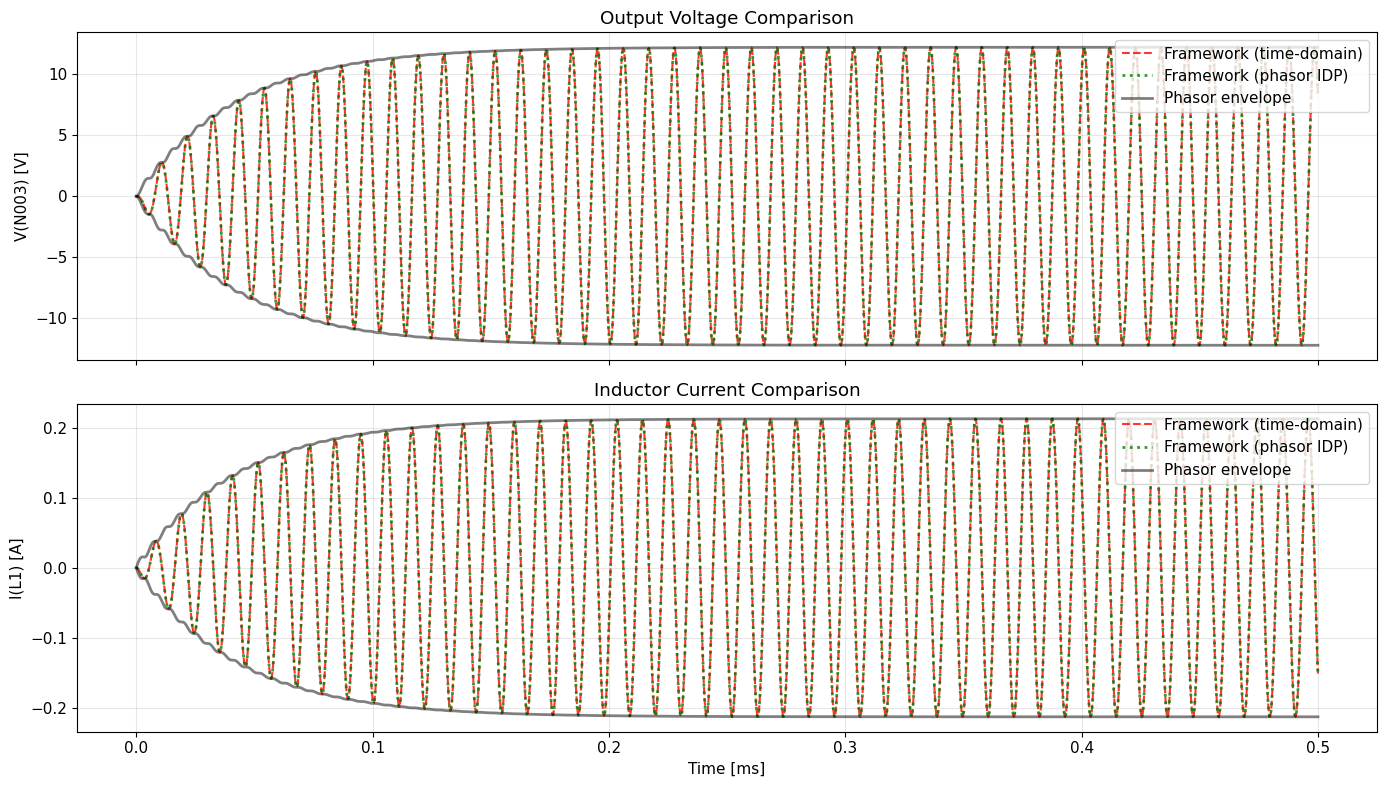

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# ── Voltage ──
ax = axes[0]
if ltspice_data is not None:
    ax.plot(t_lt*1e3, V_lt, 'b-', lw=1.0, alpha=0.6, label='LTspice')
ax.plot(t_fw*1e3, V_fw, 'r--', lw=1.5, alpha=0.8, label='Framework (time-domain)')
ax.plot(t_pd*1e3, V_pd, 'g:', lw=2.0, alpha=0.8, label='Framework (phasor IDP)')
ax.plot(t_pd*1e3, V_env, 'k-', lw=2.0, alpha=0.5, label='Phasor envelope')
ax.plot(t_pd*1e3, -V_env, 'k-', lw=2.0, alpha=0.5)
ax.set_ylabel('V(N003) [V]')
ax.set_title('Output Voltage Comparison')
ax.legend(loc='upper right')

# ── Current ──
ax = axes[1]
if ltspice_data is not None:
    ax.plot(t_lt*1e3, I_lt, 'b-', lw=1.0, alpha=0.6, label='LTspice')
ax.plot(t_fw*1e3, I_fw, 'r--', lw=1.5, alpha=0.8, label='Framework (time-domain)')
ax.plot(t_pd*1e3, I_pd, 'g:', lw=2.0, alpha=0.8, label='Framework (phasor IDP)')
ax.plot(t_pd*1e3, I_env, 'k-', lw=2.0, alpha=0.5, label='Phasor envelope')
ax.plot(t_pd*1e3, -I_env, 'k-', lw=2.0, alpha=0.5)
ax.set_ylabel('I(L1) [A]')
ax.set_xlabel('Time [ms]')
ax.set_title('Inductor Current Comparison')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 5. Transient Detail (First 100 µs)

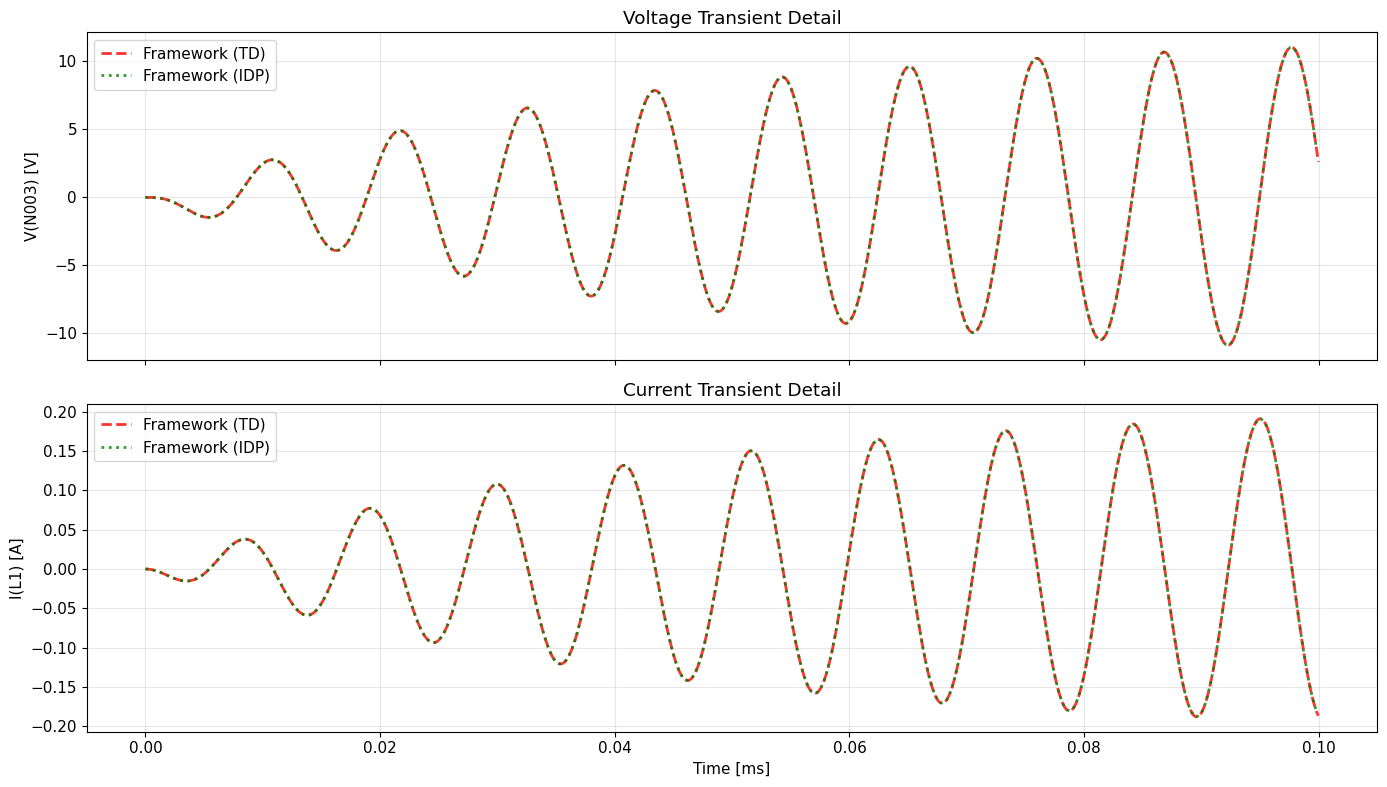

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

t_zoom = 0.1  # ms

# ── Voltage transient ──
ax = axes[0]
mask_fw = t_fw*1e3 <= t_zoom
mask_pd = t_pd*1e3 <= t_zoom
if ltspice_data is not None:
    mask_lt = t_lt*1e3 <= t_zoom
    ax.plot(t_lt[mask_lt]*1e3, V_lt[mask_lt], 'b-', lw=1.5, alpha=0.7, label='LTspice')
ax.plot(t_fw[mask_fw]*1e3, V_fw[mask_fw], 'r--', lw=2.0, alpha=0.8, label='Framework (TD)')
ax.plot(t_pd[mask_pd]*1e3, V_pd[mask_pd], 'g:', lw=2.0, alpha=0.8, label='Framework (IDP)')
ax.set_ylabel('V(N003) [V]')
ax.set_title('Voltage Transient Detail')
ax.legend()

# ── Current transient ──
ax = axes[1]
if ltspice_data is not None:
    ax.plot(t_lt[mask_lt]*1e3, I_lt[mask_lt], 'b-', lw=1.5, alpha=0.7, label='LTspice')
ax.plot(t_fw[mask_fw]*1e3, I_fw[mask_fw], 'r--', lw=2.0, alpha=0.8, label='Framework (TD)')
ax.plot(t_pd[mask_pd]*1e3, I_pd[mask_pd], 'g:', lw=2.0, alpha=0.8, label='Framework (IDP)')
ax.set_ylabel('I(L1) [A]')
ax.set_xlabel('Time [ms]')
ax.set_title('Current Transient Detail')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Error Metrics

In [8]:
def nrmse(ref, test):
    """Normalized RMSE as percentage."""
    rmse = np.sqrt(np.mean((ref - test)**2))
    rng = np.ptp(ref)
    return (rmse / rng * 100) if rng > 0 else 0.0

def peak_err(ref, test, frac=0.8):
    """Steady-state peak error as percentage."""
    s = int(frac * len(ref))
    pk_ref = np.max(np.abs(ref[s:]))
    pk_tst = np.max(np.abs(test[s:]))
    return 100 * abs(pk_ref - pk_tst) / pk_ref if pk_ref > 0 else 0.0

# Steady-state region
ss = int(0.8 * len(t_common))

print('='*70)
print('ERROR METRICS')
print('='*70)

# ── Framework Time-Domain vs Phasor-Domain ──
print('\n--- Framework: Time-Domain vs Phasor-Domain (IDP) ---')
print(f'  V(N003) NRMSE (full):  {nrmse(V_fw_c, V_pd_c):.4f}%')
print(f'  V(N003) NRMSE (SS):    {nrmse(V_fw_c[ss:], V_pd_c[ss:]):.4f}%')
print(f'  V(N003) Peak err (SS): {peak_err(V_fw_c, V_pd_c):.4f}%')
print(f'  I(L1)   NRMSE (full):  {nrmse(I_fw_c, I_pd_c):.4f}%')
print(f'  I(L1)   NRMSE (SS):    {nrmse(I_fw_c[ss:], I_pd_c[ss:]):.4f}%')
print(f'  I(L1)   Peak err (SS): {peak_err(I_fw_c, I_pd_c):.4f}%')

if ltspice_data is not None:
    # ── LTspice vs Framework Time-Domain ──
    print('\n--- LTspice vs Framework Time-Domain ---')
    print(f'  V(N003) NRMSE (full):  {nrmse(V_lt_c, V_fw_c):.4f}%')
    print(f'  V(N003) NRMSE (SS):    {nrmse(V_lt_c[ss:], V_fw_c[ss:]):.4f}%')
    print(f'  V(N003) Peak err (SS): {peak_err(V_lt_c, V_fw_c):.4f}%')
    print(f'  I(L1)   NRMSE (full):  {nrmse(I_lt_c, I_fw_c):.4f}%')
    print(f'  I(L1)   NRMSE (SS):    {nrmse(I_lt_c[ss:], I_fw_c[ss:]):.4f}%')
    print(f'  I(L1)   Peak err (SS): {peak_err(I_lt_c, I_fw_c):.4f}%')

    # ── LTspice vs Framework Phasor-Domain ──
    print('\n--- LTspice vs Framework Phasor-Domain (IDP) ---')
    print(f'  V(N003) NRMSE (full):  {nrmse(V_lt_c, V_pd_c):.4f}%')
    print(f'  V(N003) NRMSE (SS):    {nrmse(V_lt_c[ss:], V_pd_c[ss:]):.4f}%')
    print(f'  V(N003) Peak err (SS): {peak_err(V_lt_c, V_pd_c):.4f}%')
    print(f'  I(L1)   NRMSE (full):  {nrmse(I_lt_c, I_pd_c):.4f}%')
    print(f'  I(L1)   NRMSE (SS):    {nrmse(I_lt_c[ss:], I_pd_c[ss:]):.4f}%')
    print(f'  I(L1)   Peak err (SS): {peak_err(I_lt_c, I_pd_c):.4f}%')

    # ── Correlation ──
    print('\n--- Correlation Coefficients (Steady-State) ---')
    r_V_td = np.corrcoef(V_lt_c[ss:], V_fw_c[ss:])[0, 1]
    r_V_pd = np.corrcoef(V_lt_c[ss:], V_pd_c[ss:])[0, 1]
    r_I_td = np.corrcoef(I_lt_c[ss:], I_fw_c[ss:])[0, 1]
    r_I_pd = np.corrcoef(I_lt_c[ss:], I_pd_c[ss:])[0, 1]
    print(f'  V(N003): LT vs TD = {r_V_td:.6f}, LT vs IDP = {r_V_pd:.6f}')
    print(f'  I(L1):   LT vs TD = {r_I_td:.6f}, LT vs IDP = {r_I_pd:.6f}')

ERROR METRICS

--- Framework: Time-Domain vs Phasor-Domain (IDP) ---
  V(N003) NRMSE (full):  0.0000%
  V(N003) NRMSE (SS):    0.0000%
  V(N003) Peak err (SS): 0.0000%
  I(L1)   NRMSE (full):  0.0000%
  I(L1)   NRMSE (SS):    0.0000%
  I(L1)   Peak err (SS): 0.0001%


## 7. Error Waveforms

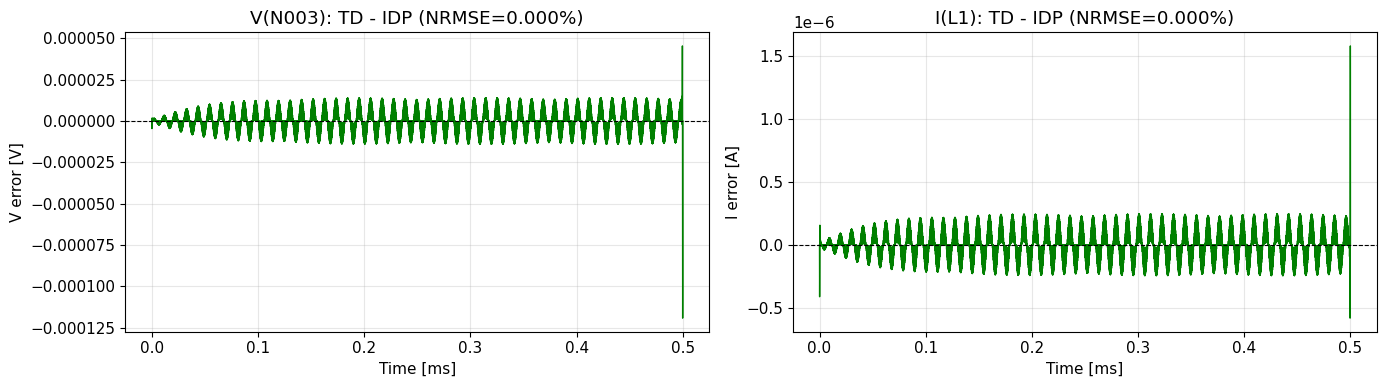

In [9]:
if ltspice_data is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))

    # ── LTspice vs Framework TD ──
    err_V_td = V_lt_c - V_fw_c
    err_I_td = I_lt_c - I_fw_c
    err_V_pd = V_lt_c - V_pd_c
    err_I_pd = I_lt_c - I_pd_c

    ax = axes[0, 0]
    ax.plot(t_common*1e3, err_V_td, 'r-', lw=1.0)
    ax.axhline(0, color='k', ls='--', lw=0.8)
    ax.set_ylabel('V error [V]')
    ax.set_title(f'V(N003): LTspice - TD (NRMSE={nrmse(V_lt_c, V_fw_c):.3f}%)')

    ax = axes[0, 1]
    ax.plot(t_common*1e3, err_V_pd, 'g-', lw=1.0)
    ax.axhline(0, color='k', ls='--', lw=0.8)
    ax.set_ylabel('V error [V]')
    ax.set_title(f'V(N003): LTspice - IDP (NRMSE={nrmse(V_lt_c, V_pd_c):.3f}%)')

    ax = axes[1, 0]
    ax.plot(t_common*1e3, err_I_td, 'r-', lw=1.0)
    ax.axhline(0, color='k', ls='--', lw=0.8)
    ax.set_ylabel('I error [A]')
    ax.set_xlabel('Time [ms]')
    ax.set_title(f'I(L1): LTspice - TD (NRMSE={nrmse(I_lt_c, I_fw_c):.3f}%)')

    ax = axes[1, 1]
    ax.plot(t_common*1e3, err_I_pd, 'g-', lw=1.0)
    ax.axhline(0, color='k', ls='--', lw=0.8)
    ax.set_ylabel('I error [A]')
    ax.set_xlabel('Time [ms]')
    ax.set_title(f'I(L1): LTspice - IDP (NRMSE={nrmse(I_lt_c, I_pd_c):.3f}%)')

    plt.tight_layout()
    plt.show()
else:
    # Show TD vs IDP error only
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    err_V = V_fw_c - V_pd_c
    err_I = I_fw_c - I_pd_c

    axes[0].plot(t_common*1e3, err_V, 'g-', lw=1.0)
    axes[0].axhline(0, color='k', ls='--', lw=0.8)
    axes[0].set_ylabel('V error [V]')
    axes[0].set_xlabel('Time [ms]')
    axes[0].set_title(f'V(N003): TD - IDP (NRMSE={nrmse(V_fw_c, V_pd_c):.3f}%)')

    axes[1].plot(t_common*1e3, err_I, 'g-', lw=1.0)
    axes[1].axhline(0, color='k', ls='--', lw=0.8)
    axes[1].set_ylabel('I error [A]')
    axes[1].set_xlabel('Time [ms]')
    axes[1].set_title(f'I(L1): TD - IDP (NRMSE={nrmse(I_fw_c, I_pd_c):.3f}%)')

    plt.tight_layout()
    plt.show()

## 8. Envelope Comparison

Compare the phasor envelope with the Hilbert-transform envelope extracted from the time-domain waveform.

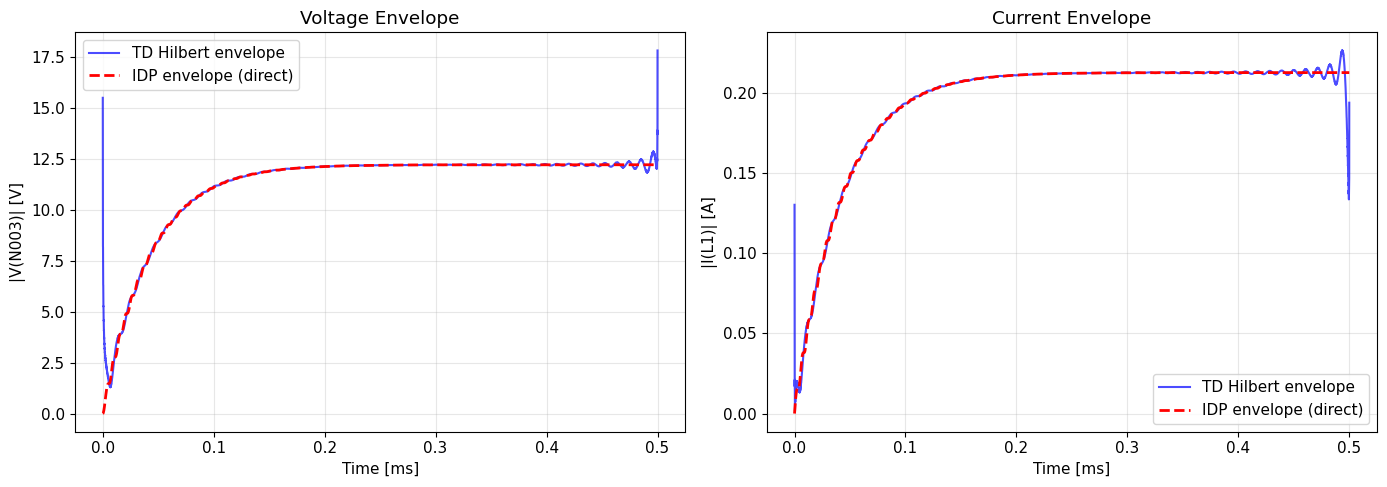

In [10]:
from scipy.signal import hilbert

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Voltage Envelope ──
ax = axes[0]
env_V_hilbert = np.abs(hilbert(V_fw))
ax.plot(t_fw*1e3, env_V_hilbert, 'b-', lw=1.5, alpha=0.7, label='TD Hilbert envelope')
ax.plot(t_pd*1e3, V_env, 'r--', lw=2.0, label='IDP envelope (direct)')
if ltspice_data is not None:
    env_V_lt_hilbert = np.abs(hilbert(V_lt))
    ax.plot(t_lt*1e3, env_V_lt_hilbert, 'g:', lw=1.5, alpha=0.7, label='LTspice Hilbert envelope')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('|V(N003)| [V]')
ax.set_title('Voltage Envelope')
ax.legend()

# ── Current Envelope ──
ax = axes[1]
env_I_hilbert = np.abs(hilbert(I_fw))
ax.plot(t_fw*1e3, env_I_hilbert, 'b-', lw=1.5, alpha=0.7, label='TD Hilbert envelope')
ax.plot(t_pd*1e3, I_env, 'r--', lw=2.0, label='IDP envelope (direct)')
if ltspice_data is not None:
    env_I_lt_hilbert = np.abs(hilbert(I_lt))
    ax.plot(t_lt*1e3, env_I_lt_hilbert, 'g:', lw=1.5, alpha=0.7, label='LTspice Hilbert envelope')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('|I(L1)| [A]')
ax.set_title('Current Envelope')
ax.legend()

plt.tight_layout()
plt.show()

## 9. Summary

In [11]:
print('='*70)
print('COMPARISON SUMMARY')
print('='*70)

# Circuit info
L = 100.04e-6; C = 30.07e-9; Rs = 3.0; Ro = 2000.0
f_r = 1/(2*np.pi*np.sqrt(L*C))
Q = np.sqrt(L/C) / Rs

print(f'\nCircuit: Rim et al. (2025) Series RLC')
print(f'  L={L*1e6:.2f}uH, C={C*1e9:.2f}nF, Rs={Rs}ohm, Ro={Ro/1e3:.0f}kohm')
print(f'  f_r={f_r/1e3:.2f} kHz, Q={Q:.1f}')
print(f'  Source: 1V @ 92.3 kHz')
print(f'  L1 Rser=1mohm (negligible, parsed but not modelled)')

# Simulation stats
print(f'\nSimulation:')
print(f'  Framework TD:  {len(t_fw):>6d} points')
print(f'  Framework IDP: {len(t_pd):>6d} points ({len(t_fw)/len(t_pd):.1f}x fewer)')
if ltspice_data is not None:
    print(f'  LTspice:       {len(t_lt):>6d} points')

# Steady-state peaks
ss_fw = int(0.8 * len(t_fw))
Vpk_fw = np.max(np.abs(V_fw[ss_fw:]))
Ipk_fw = np.max(np.abs(I_fw[ss_fw:]))
Vpk_pd = pd['envelopes']['V(N003)'][-1]
Ipk_pd = pd['envelopes']['I(L1)'][-1]

print(f'\nSteady-State Peak Values:')
print(f'  {"Method":<20s} {"V(N003) [V]":>12s} {"I(L1) [A]":>12s}')
print(f'  {"-"*20:<20s} {"-"*12:>12s} {"-"*12:>12s}')
if ltspice_data is not None:
    ss_lt = int(0.8 * len(t_lt))
    Vpk_lt = np.max(np.abs(V_lt[ss_lt:]))
    Ipk_lt = np.max(np.abs(I_lt[ss_lt:]))
    print(f'  {"LTspice":<20s} {Vpk_lt:>12.4f} {Ipk_lt:>12.6f}')
print(f'  {"Framework (TD)":<20s} {Vpk_fw:>12.4f} {Ipk_fw:>12.6f}')
print(f'  {"Framework (IDP)":<20s} {Vpk_pd:>12.4f} {Ipk_pd:>12.6f}')

# Validation
td_idp_V = nrmse(V_fw_c[ss:], V_pd_c[ss:])
td_idp_I = nrmse(I_fw_c[ss:], I_pd_c[ss:])

print(f'\nValidation (NRMSE steady-state, target <1%):')
print(f'  {"Comparison":<30s} {"V(N003)":>10s} {"I(L1)":>10s} {"Status":>8s}')
print(f'  {"-"*30:<30s} {"-"*10:>10s} {"-"*10:>10s} {"-"*8:>8s}')

p = 'PASS' if td_idp_V < 1 and td_idp_I < 1 else 'FAIL'
print(f'  {"TD vs IDP":<30s} {td_idp_V:>9.4f}% {td_idp_I:>9.4f}% {p:>8s}')

if ltspice_data is not None:
    lt_td_V = nrmse(V_lt_c[ss:], V_fw_c[ss:])
    lt_td_I = nrmse(I_lt_c[ss:], I_fw_c[ss:])
    lt_pd_V = nrmse(V_lt_c[ss:], V_pd_c[ss:])
    lt_pd_I = nrmse(I_lt_c[ss:], I_pd_c[ss:])

    p1 = 'PASS' if lt_td_V < 1 and lt_td_I < 1 else 'FAIL'
    p2 = 'PASS' if lt_pd_V < 1 and lt_pd_I < 1 else 'FAIL'
    print(f'  {"LTspice vs TD":<30s} {lt_td_V:>9.4f}% {lt_td_I:>9.4f}% {p1:>8s}')
    print(f'  {"LTspice vs IDP":<30s} {lt_pd_V:>9.4f}% {lt_pd_I:>9.4f}% {p2:>8s}')

print(f'\n{"="*70}')
print('DONE')
print('='*70)

COMPARISON SUMMARY

Circuit: Rim et al. (2025) Series RLC
  L=100.04uH, C=30.07nF, Rs=3.0ohm, Ro=2kohm
  f_r=91.76 kHz, Q=19.2
  Source: 1V @ 92.3 kHz
  L1 Rser=1mohm (negligible, parsed but not modelled)

Simulation:
  Framework TD:    9230 points
  Framework IDP:   2000 points (4.6x fewer)

Steady-State Peak Values:
  Method                V(N003) [V]    I(L1) [A]
  -------------------- ------------ ------------
  Framework (TD)            12.2000     0.212840
  Framework (IDP)           12.2000     0.212840

Validation (NRMSE steady-state, target <1%):
  Comparison                        V(N003)      I(L1)   Status
  ------------------------------ ---------- ---------- --------
  TD vs IDP                         0.0000%    0.0000%     PASS

DONE
